# Finding Period and Initial Best Fit

In [1]:
#Importing and notebook setup
%matplotlib inline
import os

#For Plotting
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy import optimize
from gatspy.periodic import LombScargleFast

#Making Tables
from tabulate import tabulate

#for Radvel
import matplotlib
import pylab as pl

import corner

#importing radvel
import radvel
import radvel.plotting

matplotlib.rcParams['font.size'] = 14

Define Periodogram Function

In [2]:
def periodogram(datax, datay, min_, max_, nyquist):
    #finding periodogram
    model = LombScargleFast().fit(datax, datay)
    period, power = model.periodogram_auto(nyquist_factor=nyquist) # Default 50

    #Plotting
    plt.figure
    plt.plot(period,power)
    plt.ylabel('Power')
    plt.xlabel('Period')# days
    plt.xscale('log')
    #used bottom line to zoom in periodogram
#     plt.xlim(min_-1,max_+10)

    # set range and find period
    model.optimizer.period_range=(min_, max_)
    period = model.best_period
    print("period = {0}".format(period))
    return period

Function for RadVel and Residuals

Define a Plotting Function to Display the Data, Model, and Residuals

In [3]:
#used for plotting radvel plots
def plot_results(like):
    fig = pl.figure(figsize=(12,4))
    fig = pl.gcf()
    pl.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    pl.plot(ti, like.model(ti))
    fig.set_tight_layout(True)
    pl.xlabel('Time')
    pl.ylabel('RV')
    pl.draw()

Define RMS Function

In [4]:
#getting RMS
def RMS (Residuals):
    RMS = np.std(Residuals)
    return RMS

Using Radvel to Find Model Likelihood

In [5]:
def model_likelihood(post,show=False):
    num_planet = post.likelihood.model.num_planets
    ndata = len(post.likelihood.y)
    nfree = len(post.get_vary_params())
    rms = np.std(post.likelihood.residuals())
    logprob = post.logprob()
    chi = np.sum((post.likelihood.residuals()/post.likelihood.errorbars())**2)
    chi_red = chi / (ndata - nfree)
    bic = post.bic()
    if show:
        print "N_free = %d" % nfree
        print "RMS = %4.2f" % np.std(post.likelihood.residuals())
        print "logprob (jitter fixed) = %4.2f" % post.logprob()
        print "chi (jitter fixed) = %4.2f" % chi
        print "chi_red (jitter fixed) = %4.2f" % chi_red
        print "BIC (jitter fixed) = %4.2f" % post.bic()
        
    model_likelihood = [num_planet, ndata, nfree, rms, logprob, chi , chi_red, bic]
    return model_likelihood

My Own Method of Modeling Data

In [6]:
#My own method of plotting and finding likelihood
def residuals(num_planet,data_x, data_y,data_err,amplitude,period,phase_shift,vertical_shift):
    # Target function
    fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x
    #Distance to the target function
    errfunc = lambda p, x, y: fitfunc(p, x) - y 
    
    # Initial guess for the first set's parameters
    p0 = [amplitude, period, phase_shift, vertical_shift]
    p1, success = optimize.leastsq(errfunc, p0[:], args=(data_x, data_y))
    
    print 'Amplitude: ', np.absolute(p1[0])
    print 'Period: ', p1[1]
    print 'Phase Shift: ', p1[2]
    print 'Vertical-Shift: ',p1[3]
    period = p1[1]
    
    #Finding Residuals
    Residuals = data_y - fitfunc(p1,data_x)
    
    #Finding Likelihood
    ndata = len(data_x)
    nfree = 4.
    RMS = np.std(Residuals)
    logprob = np.log(np.sum(Residuals))
    chi = np.sum(((Residuals)/data_err)**2)
    chi_red = chi / (ndata - nfree)
#     bic = -2.0 * self.logprob() + len(self.likelihood.get_vary_params()) + np.log(len(self.likelihood.y))
    bic = np.log(ndata)+nfree +-2.*logprob
    #chisquared = sum(Residuals**2/(fitfunc(p1,data_x)))
    print "RMS of Residuals: ", RMS
    print "RMS", RMS
    print 'Chi Square', chi
    likelihood = [num_planet, ndata, nfree, RMS, logprob, chi , chi_red, bic]
    
    #Plotting Data with Fit
    time = np.linspace(data_x.min(), data_x.max(), 1000*len(data_x))
    plt.plot(data_x, data_y, "go", time, fitfunc(p1, time),"b-",alpha=0.5)
    plt.title('HD217014')
    plt.xlabel('Time [JD-2.44e6]')
    plt.ylabel('Mean Velocity[m/s]')
    plt.legend(('Data', 'Fit'))
    plt.xlim(data_x[0]-5,data_x[-1]+5)
    ax1 = plt.axes()
    plt.show()
    
    #plotting Residuals
    #plt.plot(data_x, Residuals, "ro", time, fitfunc(p2, time),"b-")
    plt.plot(data_x, Residuals, "ro")
    plt.xlim(data_x[0]-5,data_x[-1]+5)
    plt.ylim(-max(data_y)-10, max(data_y)+10)
    plt.title('Residuals')
    plt.xlabel('Time [JD-2.44e6]')
    plt.ylabel('Mean Velocity[m/s]')
    plt.legend(('Residuals', 'Fit'))
    ax2 = plt.axes()
    
    
    return Residuals, period, likelihood

Importing Data

In [7]:
#Data import
data= pd.read_csv('C:/users/rscsa/Research/radvel-master/research/HD75732/HD75732.csv')

#data from different telescopes
data_rk = data[0:23]
data_rj = data[24:653]

#Naming Variables from data
t = np.array(data_rj.jd)
vel = np.array(data_rj.mnvel)
errvel = np.array(data_rj.errvel)
# tel = np.array(data_rj.tel)

#time vector for best fit
ti = np.linspace(t.min(),t.max(),num=len(t)* 10000)
# print data

# Finding Period in Data (1st Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 14.6521574048


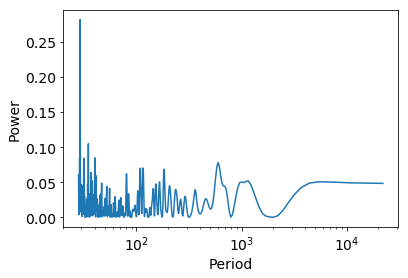

In [8]:
#nyquist - min period for data
nyquist = .5
#finding first planet period
period1 = periodogram(t,vel,1,max(t)-min(t),nyquist)

Initializing Radvel

In [9]:
nplanets = 1
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = period1    # period of 1st planet
    params['tc1'] = 2074.52   # time of inferior conjunction of 1st planet
    params['secosw1'] = 0.01 
    params['sesinw1'] =  0.01 
    params['logk1'] =  np.log(50)   # velocity semi-amplitude for 1st planet  
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

In [10]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

# like.params['gamma_k'] = 0.0
# like.params['gamma_j'] = 1.0
# like.params['jit_k'] = 2.6
# like.params['jit_j'] = 2.6

Defining Variables that are Going to Vary.

In [11]:
like.vary['curv'] = True
like.vary['dvdt'] = True
#like.vary['per1'] = False
#like.vary['logk1'] = False
#like.vary['secosw1'] = False
#like.vary['sesinw1'] = False
#like.vary['tc1'] = False

Plotting Radvels Initial Likelihood

C:\Users\rscsa\Anaconda2\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


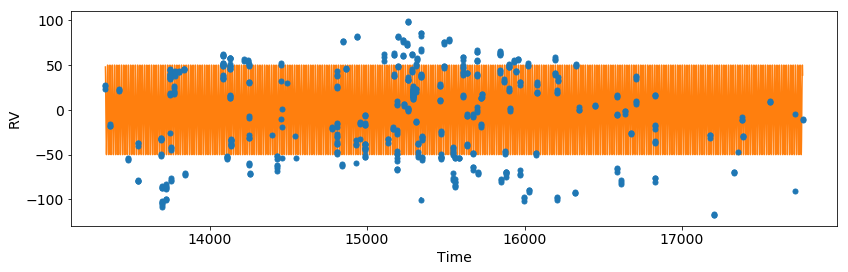

In [12]:
pl.figure()
plot_results(like)
# radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

Maximize the Likelihood and Print the Updated Posterior Object

In [13]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]
#post.priors += [radvel.prior.Gaussian( 'jit_k', np.log(1), np.log(15))]
#post.priors += [radvel.prior.Gaussian( 'jit_j', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6522       True
tc1                         2074.52       True
secosw1                        0.01       True
sesinw1                        0.01       True
logk1                       3.91202       True
dvdt                              0       True
curv                              0       True
jit                             2.6       True
gamma                             1       True

Priors
------
Gaussian prior on per1, mu=14.6521574048, sigma=3.66303935119
e1 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



parameter                     value      vary
per1                        14.6518       True
tc1                         2074.48       True
secosw1                   0.0798337       True
sesinw1                  -0.0809386       True
logk1                       4.17498       True
dvdt                   -0.000776938       True
curv                   -7.16438e-09       True
jit                         21.3251       True
gamma                       2.72031       True

Priors
------
Gaussian prior on per1, mu=14.6521574048, sigma=3.66303935119
e1 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



C:\Users\rscsa\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(<matplotlib.figure.Figure at 0xeecbeb8>,
  <matplotlib.axes._subplots.AxesSubplot at 0xf5d8c50>])

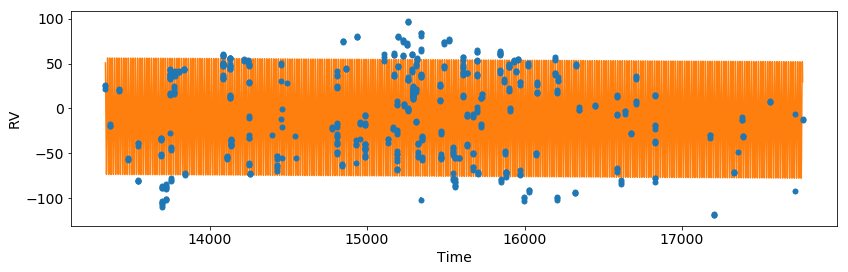

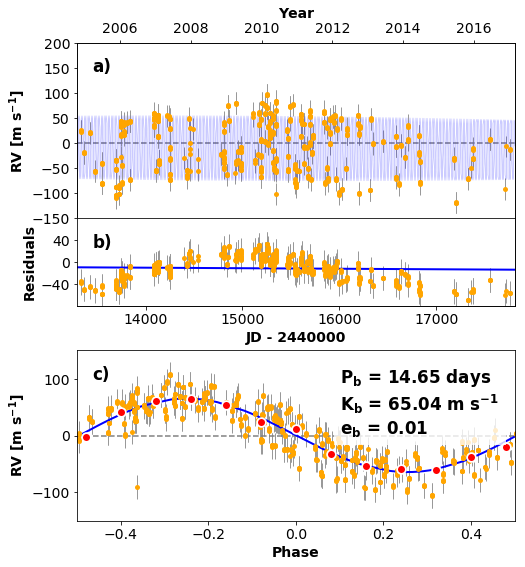

In [14]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )
#Get residuals
#orbel = []
#radvel.kepler.rv_drive(t)
plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post,epoch=2440000)

In [15]:
# res  = optimize.minimize(
#     post.neglogprob_array,     # objective function is negative log likelihood
#     post.get_vary_params(),    # initial variable parameters
#     method='Powell',           # Nelder-Mead also works
#     )
# #Get residuals
# #orbel = []
# #radvel.kepler.rv_drive(t)
# plot_results(like)             # plot best fit model
# print post
# radvel.plotting.rv_multipanel_plot(post, telfmts=radvel.plotting.telfmts_default,epoch=2440000)

Finding the Model Likelihood, using RMS, Chi Squared, Log Probability, & BIC

In [16]:
Residuals_Radvel_1 = post.likelihood.residuals()
RMS_Radvel_1 = RMS(Residuals_Radvel_1)
print 'Radvel RMS of Residuals: ', RMS_Radvel_1
print ' '
print ' '

one_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  22.360981816
 
 
N_free = 9
RMS = 22.36
logprob (jitter fixed) = -2879.07
chi (jitter fixed) = 689.43
chi_red (jitter fixed) = 1.11
BIC (jitter fixed) = 5773.59


# Initial Best Fit My Own Way (1st Planet)

Finding Model for Data

Amplitude:  64.801436309
Period:  14.6530055197
Phase Shift:  -1.59442142435
Vertical-Shift:  -0.000536193798557
RMS of Residuals:  22.3551287245
RMS 22.3551287245
Chi Square 324902.149296


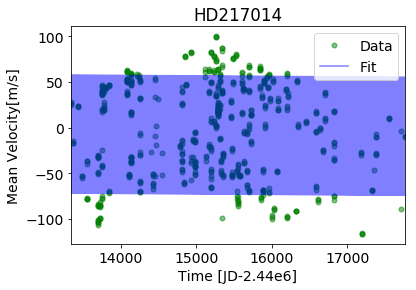

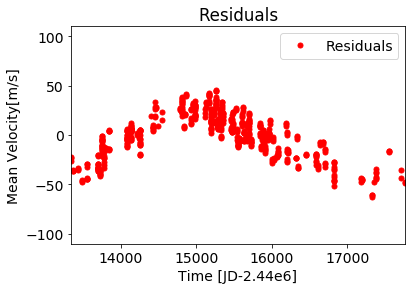

In [17]:
guess_amp = 50.
guess_pshft =0.
guess_vshft = 0.
residuals1, period1, likelihood1 = residuals(nplanets,t,vel,errvel,guess_amp,period1,guess_pshft,guess_vshft)

# Finding Period for 2nd Planet

Looking at Residuals for another Period

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 3782.78629915


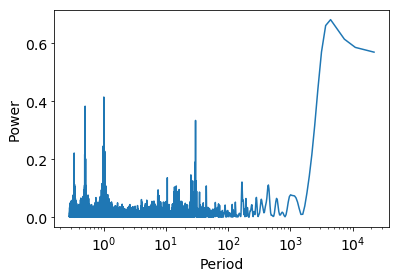

In [18]:
period_radvel_2 = periodogram(t,Residuals_Radvel_1,1,max(t)-min(t),50)

In [19]:
nplanets = 2
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = period_radvel_2 
    params['tc2'] =  4268.95 + 1000   
    params['secosw2'] = 0.01  
    params['sesinw2'] = 0.01 
    params['logk2'] = np.log(RMS_Radvel_1)   
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

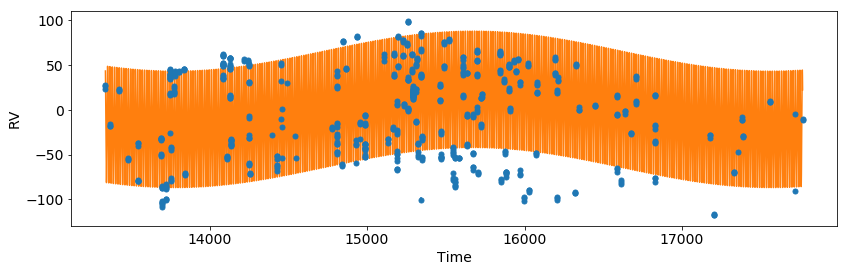

In [20]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [21]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6518       True
tc1                         2074.48       True
secosw1                   0.0798337       True
sesinw1                  -0.0809386       True
logk1                       4.17498       True
per2                        3782.79       True
tc2                         5268.95       True
secosw2                        0.01       True
sesinw2                        0.01       True
logk2                       3.10732       True
dvdt                              0       True
curv                              0       True
jit                             2.6       True
gamma                             1       True

Priors
------
Gaussian prior on per1, mu=14.6518449725, sigma=3.66296124313
Gaussian prior on per2, mu=3782.78629915, sigma=945.696574786
e1 constrained to be < 0.99
e2 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



C:\Users\rscsa\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\rscsa\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:1881: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)


parameter                     value      vary
per1                        14.6507       True
tc1                         2075.33       True
secosw1                    0.182707       True
sesinw1                    0.127073       True
logk1                       4.23345       True
per2                        2855.42       True
tc2                         4569.65       True
secosw2                   -0.425635       True
sesinw2                    0.164741       True
logk2                       3.22722       True
dvdt                    -0.00329398       True
curv                    -1.9268e-07       True
jit                         14.3855       True
gamma                       63.5789       True

Priors
------
Gaussian prior on per1, mu=14.6518449725, sigma=3.66296124313
Gaussian prior on per2, mu=3782.78629915, sigma=945.696574786
e1 constrained to be < 0.99
e2 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



(<matplotlib.figure.Figure at 0x1d77a780>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1d0a4320>])

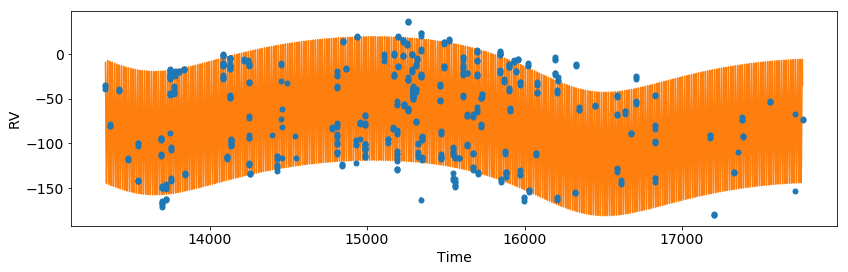

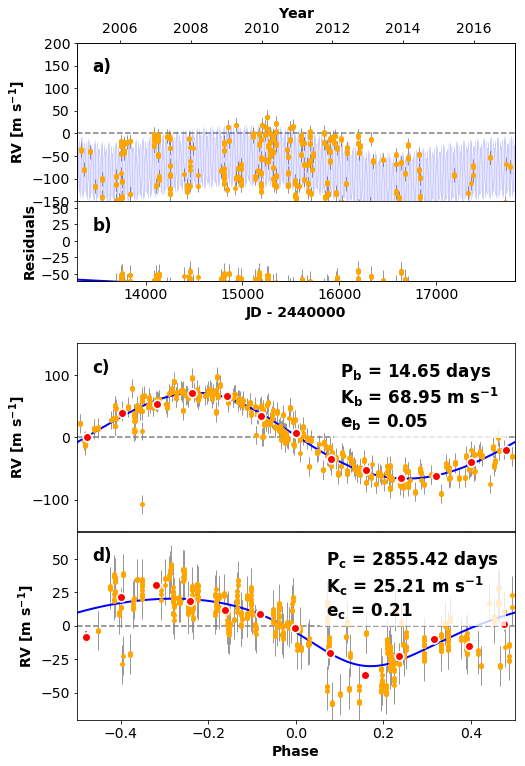

In [22]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [23]:
# res  = optimize.minimize(
#     post.neglogprob_array,     # objective function is negative log likelihood
#     post.get_vary_params(),    # initial variable parameters
#     method='Powell',           # Nelder-Mead also works
#     )
# #Get residuals
# #orbel = []
# #radvel.kepler.rv_drive(t)
# plot_results(like)             # plot best fit model
# print post
# radvel.plotting.rv_multipanel_plot(post, telfmts=radvel.plotting.telfmts_default,epoch=2440000)

In [24]:
Residuals_Radvel_2 = post.likelihood.residuals()
RMS_Radvel_2 = RMS(Residuals_Radvel_2)
print 'Radvel RMS of Residuals: ', RMS_Radvel_2
print ' '
print ' '

#Model Likelihood
two_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  14.8438334637
 
 
N_free = 14
RMS = 14.84
logprob (jitter fixed) = -2602.28
chi (jitter fixed) = 662.30
chi_red (jitter fixed) = 1.08
BIC (jitter fixed) = 5225.01


# Initial Best Fit My Own Way (2nd Planet)

Period for my own method

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 3909.77029152


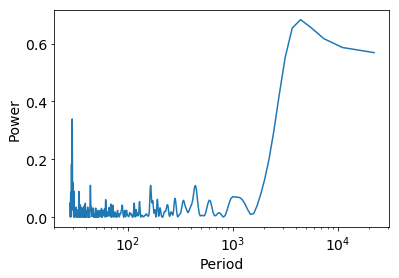

In [25]:
period2 = periodogram(t,residuals1,1,max(t)-min(t),nyquist)

Amplitude:  30.6992890461
Period:  4264.07023268
Phase Shift:  3.00918256009
Vertical-Shift:  -0.000657741056046
RMS of Residuals:  12.6265207954
RMS 12.6265207954
Chi Square 82813.3716966


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


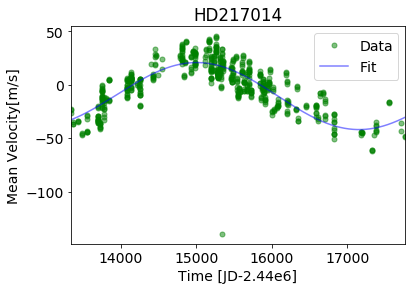

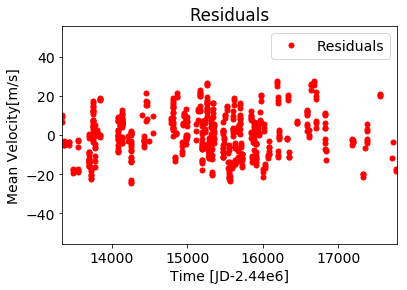

In [26]:
guess_amp = 30.
guess_pshft = 0.
guess_vshft = 0.
residuals2, period2, likelihood2 = residuals(nplanets, t, residuals1, errvel, guess_amp, period2, guess_pshft, guess_vshft)

# Finding Period for Planet 3

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 44.4069188088


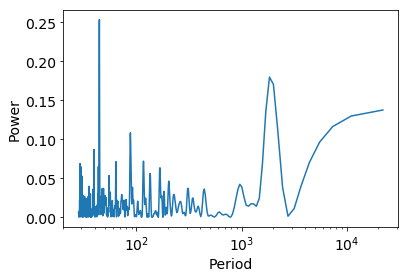

In [27]:
period_radvel_3 = periodogram(t,Residuals_Radvel_2,1,max(t)-min(t),nyquist)

In [28]:
nplanets = 3
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2'] 

    #3rd Planet
    params['per3'] = period_radvel_3
    params['tc3'] = 2087.07 
    params['secosw3'] = 0.01
    params['sesinw3'] =  0.01 
    params['logk3'] = np.log(RMS_Radvel_2)
    
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

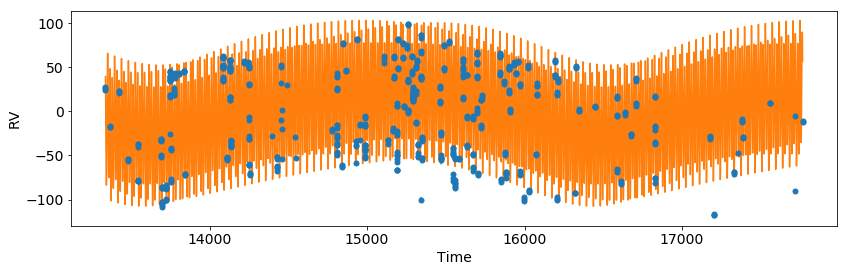

In [29]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [30]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6507       True
tc1                         2075.33       True
secosw1                    0.182707       True
sesinw1                    0.127073       True
logk1                       4.23345       True
per2                        2855.42       True
tc2                         4569.65       True
secosw2                   -0.425635       True
sesinw2                    0.164741       True
logk2                       3.22722       True
per3                        44.4069       True
tc3                         2087.07       True
secosw3                        0.01       True
sesinw3                        0.01       True
logk3                       2.69758       True
dvdt                              0       True
curv                              0       True
jit                             2.6       True
gamma                             1       True

Priors
------
Gaussian prior on per1, mu=14.6507219212, sigm

parameter                     value      vary
per1                        14.6534       True
tc1                         2073.05       True
secosw1                   0.0123893       True
sesinw1                     0.13959       True
logk1                       4.25679       True
per2                        3546.25       True
tc2                         1905.52       True
secosw2                   -0.135813       True
sesinw2                   -0.459131       True
logk2                       3.35122       True
per3                        44.3365       True
tc3                         2098.74       True
secosw3                    0.533826       True
sesinw3                    0.259509       True
logk3                       2.41136       True
dvdt                    -0.00427168       True
curv                   -1.28966e-07       True
jit                         9.59379       True
gamma                       64.3837       True

Priors
------
Gaussian prior on per1, mu=14.6507219212, sigm

(<matplotlib.figure.Figure at 0xdb44b70>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1d3ffc88>])

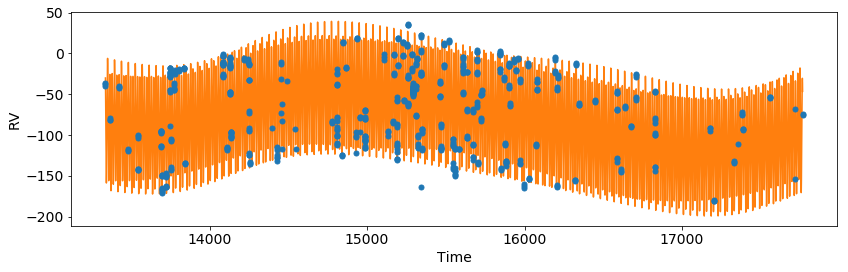

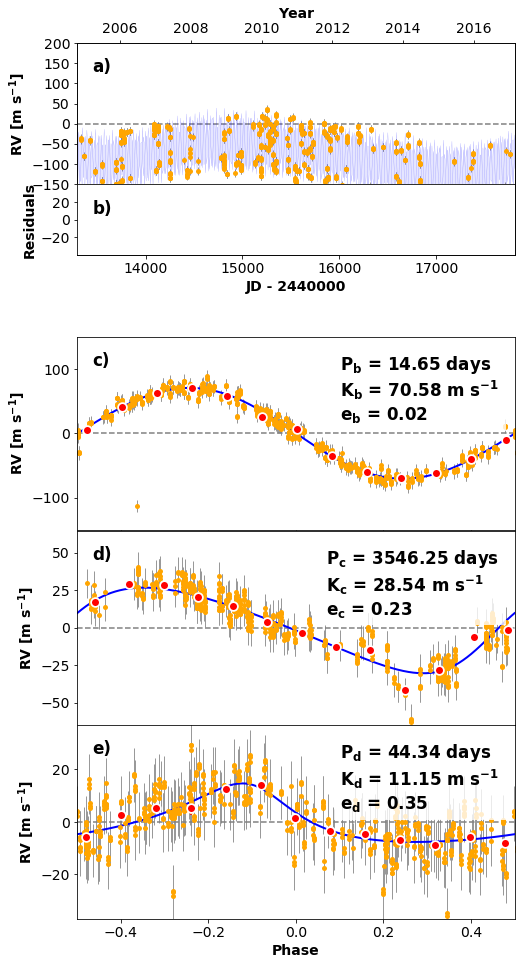

In [31]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [32]:
# res  = optimize.minimize(
#     post.neglogprob_array,     # objective function is negative log likelihood
#     post.get_vary_params(),    # initial variable parameters
#     method='Powell',           # Nelder-Mead also works
#     )
# #Get residuals
# #orbel = []
# #radvel.kepler.rv_drive(t)
# plot_results(like)             # plot best fit model
# print post
# radvel.plotting.rv_multipanel_plot(post, telfmts=radvel.plotting.telfmts_default,epoch=2440000)

In [33]:
Residuals_Radvel_3 = post.likelihood.residuals()
RMS_Radvel_3 = RMS(Residuals_Radvel_3)
print 'Radvel RMS of Residuals: ', RMS_Radvel_3
print ' '
print ' '

#model likelihood
three_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  10.0077838752
 
 
N_free = 19
RMS = 10.01
logprob (jitter fixed) = -2337.97
chi (jitter fixed) = 655.32
chi_red (jitter fixed) = 1.07
BIC (jitter fixed) = 4701.38


# Initial Best Fit My Own Way (3rd Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 44.3882132828


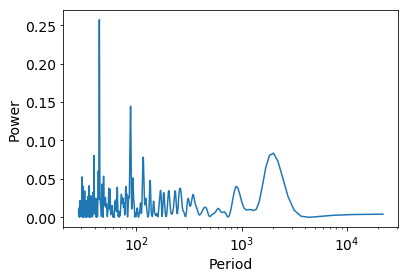

In [34]:
period3 = periodogram(t,residuals2,1,max(t)-min(t),nyquist)

Amplitude:  8.9857357728
Period:  44.396084916
Phase Shift:  1.84784457954
Vertical-Shift:  2.02699264661e-05
RMS of Residuals:  10.8820245297
RMS 10.8820245297
Chi Square 54449.1584017


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


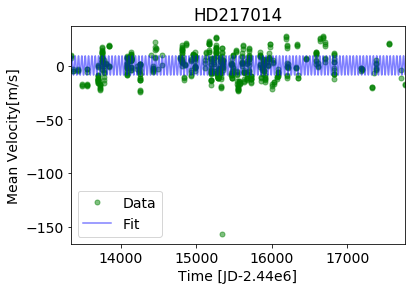

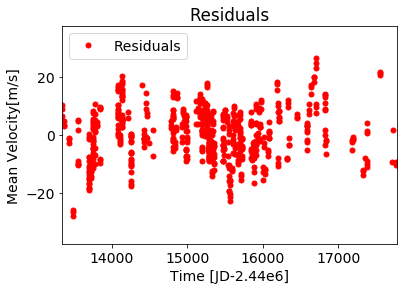

In [35]:
guess_amp = 20.
guess_pshft =0.
guess_vshft = 0.
residuals3, period3, likelihood3 = residuals(nplanets, t, residuals2, errvel, guess_amp, period3, guess_pshft, guess_vshft)

# Finding 4th Planet

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 2.81772688321


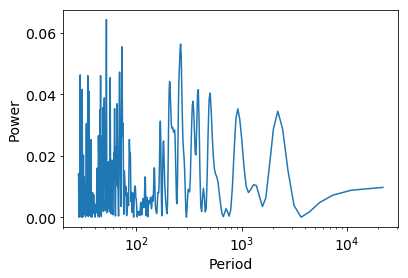

In [36]:
period_radvel_4 = periodogram(t,Residuals_Radvel_3,1,max(t)-min(t),nyquist)

In [37]:
nplanets = 4
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2']  

    #3rd Planet
    params['per3'] = post.params['per3']
    params['tc3'] = post.params['tc3']
    params['secosw3'] = post.params['secosw3']
    params['sesinw3'] =  post.params['sesinw3']
    params['logk3'] = post.params['logk3']
    
    #4th Planet
    params['per4'] = period_radvel_4
    params['tc4'] = 2087.07 -1000   
    params['secosw4'] = 0.01
    params['sesinw4'] = 0.01
    params['logk4'] = np.log(RMS_Radvel_3)   
 
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

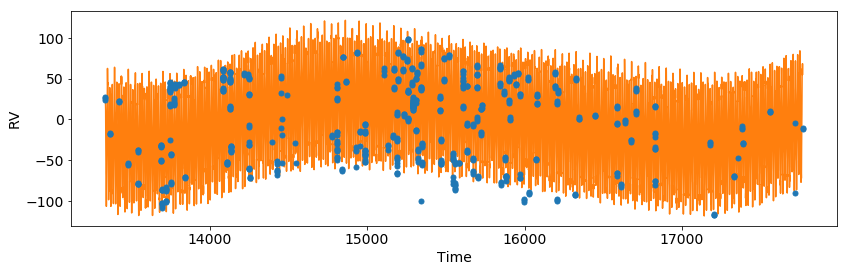

In [38]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [39]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]
post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],.25*like.params['per4'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6534       True
tc1                         2073.05       True
secosw1                   0.0123893       True
sesinw1                     0.13959       True
logk1                       4.25679       True
per2                        3546.25       True
tc2                         1905.52       True
secosw2                   -0.135813       True
sesinw2                   -0.459131       True
logk2                       3.35122       True
per3                        44.3365       True
tc3                         2098.74       True
secosw3                    0.533826       True
sesinw3                    0.259509       True
logk3                       2.41136       True
per4                        2.81773       True
tc4                         1087.07       True
secosw4                        0.01       True
sesinw4                        0.01       True
logk4                       2.30336       True
dvdt          

parameter                     value      vary
per1                        14.6525       True
tc1                         2073.91       True
secosw1                    0.074112       True
sesinw1                    0.139687       True
logk1                       4.25603       True
per2                        3659.49       True
tc2                         1360.74       True
secosw2                  -0.0204134       True
sesinw2                    -0.45568       True
logk2                       3.39661       True
per3                        44.3645       True
tc3                         2090.22       True
secosw3                    0.530549       True
sesinw3                    0.284665       True
logk3                       2.40529       True
per4                        3.62418       True
tc4                         1084.74       True
secosw4                    0.258818       True
sesinw4                   -0.875308       True
logk4                       1.14398       True
dvdt          

(<matplotlib.figure.Figure at 0x19fe1908>,
  <matplotlib.axes._subplots.AxesSubplot at 0x19966240>])

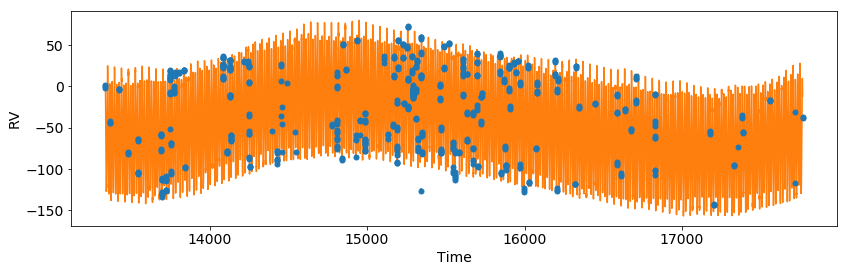

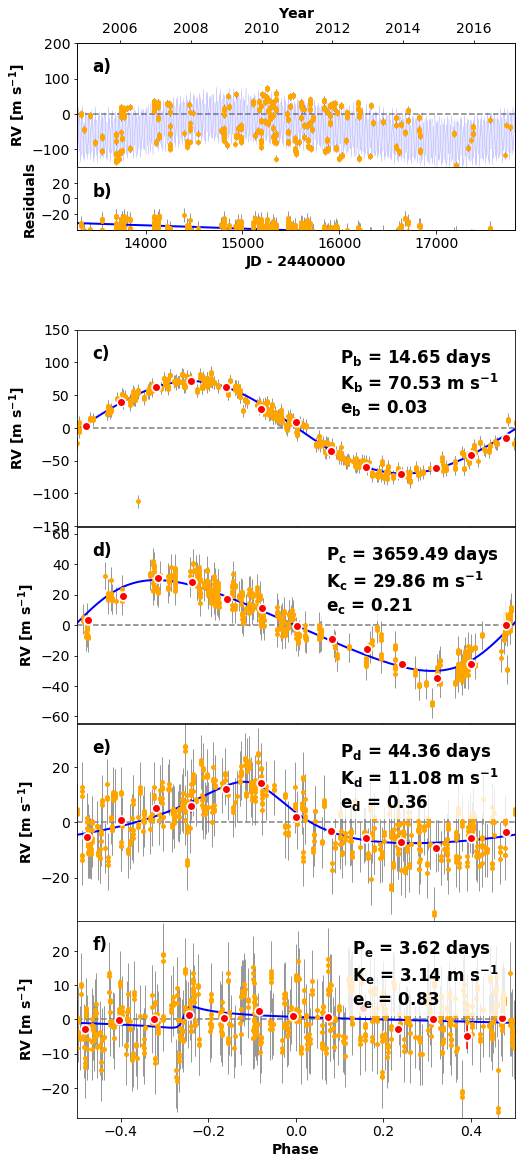

In [40]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [41]:
# res  = optimize.minimize(
#     post.neglogprob_array,     # objective function is negative log likelihood
#     post.get_vary_params(),    # initial variable parameters
#     method='Powell',           # Nelder-Mead also works
#     )
# #Get residuals
# #orbel = []
# #radvel.kepler.rv_drive(t)
# plot_results(like)             # plot best fit model
# print post
# radvel.plotting.rv_multipanel_plot(post, telfmts=radvel.plotting.telfmts_default,epoch=2440000)

In [42]:
Residuals_Radvel_4 = post.likelihood.residuals()
RMS_Radvel_4 = RMS(Residuals_Radvel_4)
print 'Radvel RMS of Residuals: ', RMS_Radvel_4
print ' '
print ' '

#model likelihood
four_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  9.45288509316
 
 
N_free = 24
RMS = 9.45
logprob (jitter fixed) = -2298.85
chi (jitter fixed) = 666.24
chi_red (jitter fixed) = 1.10
BIC (jitter fixed) = 4628.15


# Initial Best Fit My Own Way (4th Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 2.81733586558


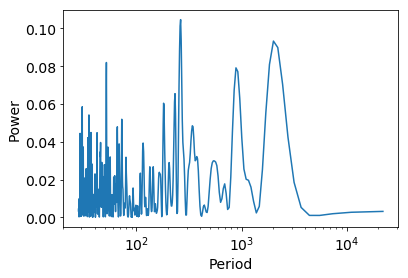

In [43]:
period4 = periodogram(t,residuals3,1,max(t)-min(t),nyquist)

Amplitude:  5.57470557343
Period:  2.81734484973
Phase Shift:  -0.216421697655
Vertical-Shift:  1.20483570578e-05
RMS of Residuals:  10.1221438257
RMS 10.1221438257
Chi Square 44432.0435588


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


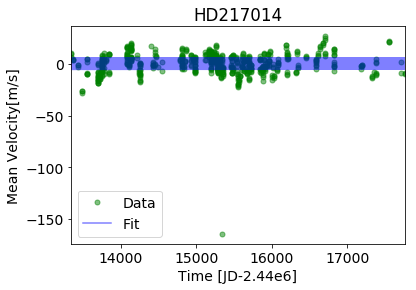

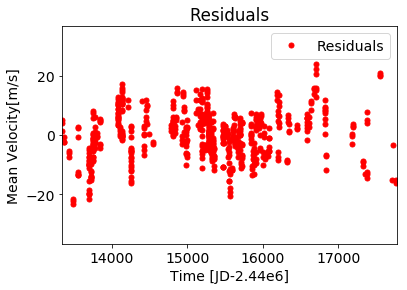

In [44]:
guess_amp = 15.
guess_pshft =0.
guess_vshft = 0.
residuals4, period4, likelihood4 = residuals(nplanets, t, residuals3, errvel, guess_amp, period4, guess_pshft, guess_vshft)

# 5th Planet Period

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1.2 to 4.4e+03
 - Computing periods at 18438 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 2.81753315449


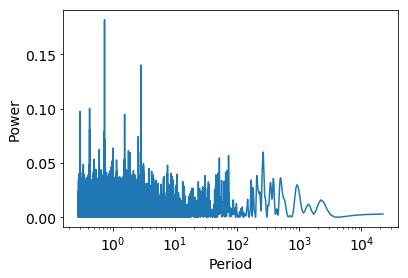

In [45]:
period_radvel_5 = periodogram(t,Residuals_Radvel_4,1.2,max(t)-min(t),50)
period_radvel_5 = 259.7

In [46]:
nplanets = 5
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2']  

    #3rd Planet
    params['per3'] = post.params['per3']
    params['tc3'] = post.params['tc3']
    params['secosw3'] = post.params['secosw3']
    params['sesinw3'] =  post.params['sesinw3']
    params['logk3'] = post.params['logk3']
    
    #4th Planet
    params['per4'] = post.params['per4']
    params['tc4'] = post.params['tc4']
    params['secosw4'] = post.params['secosw4']
    params['sesinw4'] = post.params['sesinw4']
    params['logk4'] = post.params['logk4']
    
    #5th Planet
    params['per5'] = period_radvel_5
    params['tc5'] = 2087.07  
    params['secosw5'] = 0.01
    params['sesinw5'] = 0.01
    params['logk5'] = np.log(RMS_Radvel_4)  
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

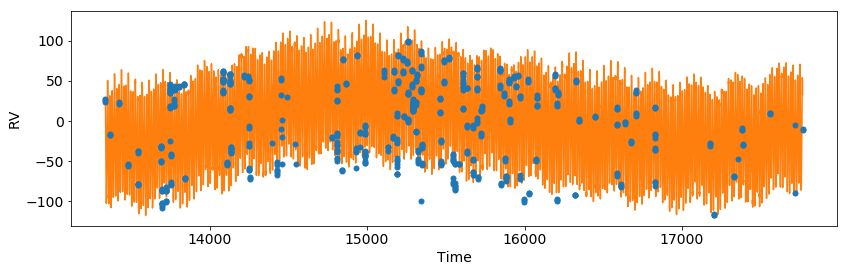

In [47]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [48]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]
post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],.25*like.params['per4'])]
post.priors += [radvel.prior.Gaussian('per5',like.params['per5'],.25*like.params['per5'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6525       True
tc1                         2073.91       True
secosw1                    0.074112       True
sesinw1                    0.139687       True
logk1                       4.25603       True
per2                        3659.49       True
tc2                         1360.74       True
secosw2                  -0.0204134       True
sesinw2                    -0.45568       True
logk2                       3.39661       True
per3                        44.3645       True
tc3                         2090.22       True
secosw3                    0.530549       True
sesinw3                    0.284665       True
logk3                       2.40529       True
per4                        3.62418       True
tc4                         1084.74       True
secosw4                    0.258818       True
sesinw4                   -0.875308       True
logk4                       1.14398       True
per5          

C:\Users\rscsa\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:1877: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


parameter                     value      vary
per1                        14.6518       True
tc1                          2074.5       True
secosw1                   0.0409944       True
sesinw1                    0.109144       True
logk1                       4.26193       True
per2                        3775.05       True
tc2                         867.559       True
secosw2                   0.0721263       True
sesinw2                   -0.438416       True
logk2                       3.41643       True
per3                        44.3905       True
tc3                         2082.64       True
secosw3                    0.541054       True
sesinw3                     0.18203       True
logk3                       2.33923       True
per4                        2.94665       True
tc4                         1084.94       True
secosw4                     0.26393       True
sesinw4                   -0.899185       True
logk4                       1.78685       True
per5          

(<matplotlib.figure.Figure at 0x1afd9d68>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a141390>])

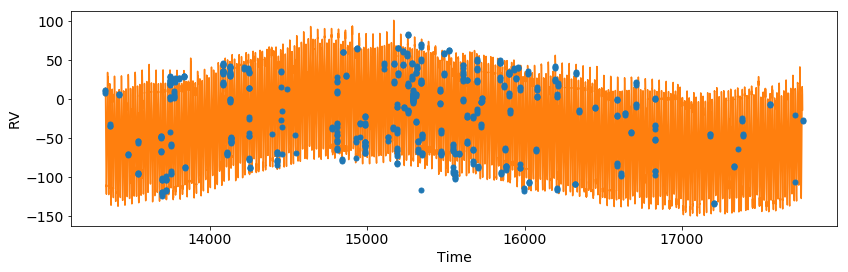

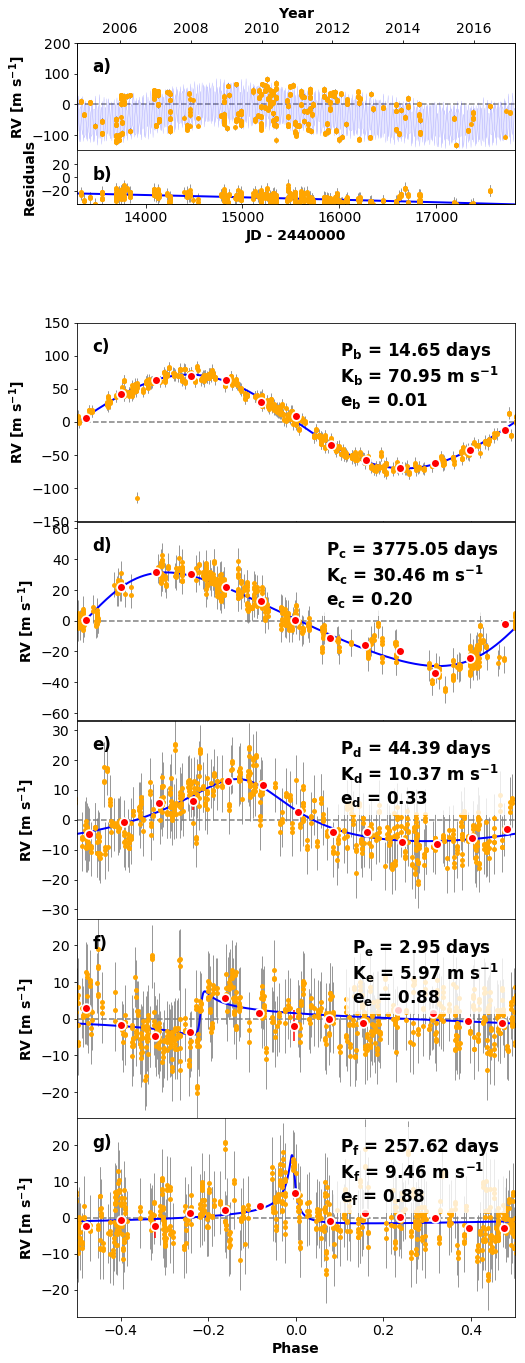

In [49]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [50]:
# res  = optimize.minimize(
#     post.neglogprob_array,     # objective function is negative log likelihood
#     post.get_vary_params(),    # initial variable parameters
#     method='Powell',           # Nelder-Mead also works
#     )
# #Get residuals
# #orbel = []
# #radvel.kepler.rv_drive(t)
# plot_results(like)             # plot best fit model
# print post
# radvel.plotting.rv_multipanel_plot(post, telfmts=radvel.plotting.telfmts_default,epoch=2440000)

In [51]:
Residuals_Radvel_5 = post.likelihood.residuals()
RMS_Radvel_5 = RMS(Residuals_Radvel_5)
print 'Radvel RMS of Residuals: ', RMS_Radvel_5
print ' '
print ' '

#model likelihood
five_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  8.73293898809
 
 
N_free = 29
RMS = 8.73
logprob (jitter fixed) = -2241.75
chi (jitter fixed) = 677.20
chi_red (jitter fixed) = 1.13
BIC (jitter fixed) = 4518.95


# Initial Best Fit My Own Way (5th Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  15 to 1.5e+03
 - Computing periods at 1462 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 263.090544328


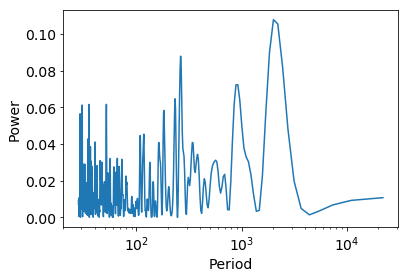

In [52]:
period5 = periodogram(t,residuals4,15,1500,nyquist)

Amplitude:  4.06509134648
Period:  263.688790468
Phase Shift:  -0.251522183567
Vertical-Shift:  2.66414662799e-05
RMS of Residuals:  9.6645426048
RMS 9.6645426048
Chi Square 38571.6888704


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


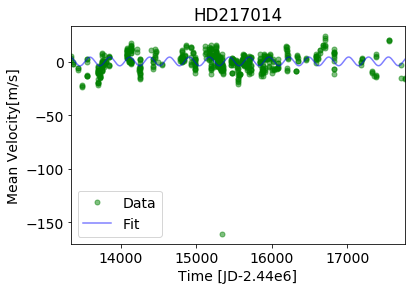

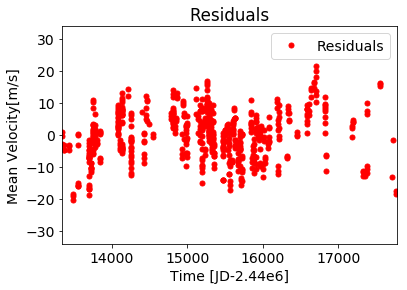

In [53]:
guess_amp = 10.
guess_pshft =0.
guess_vshft = 0.
residuals5, period5, likelihood5 = residuals(nplanets, t, residuals4, errvel, guess_amp, period5, guess_pshft, guess_vshft)

# Possible 6th Planet

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1.2 to 2e+02
 - Computing periods at 18332 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 2.81711834201


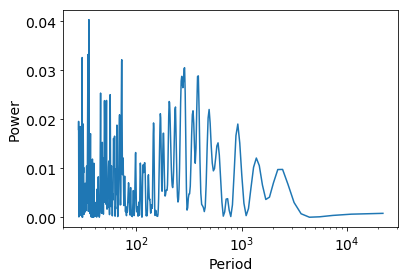

In [54]:
period_radvel_6 = periodogram(t,Residuals_Radvel_5,1.2,200,nyquist)

In [55]:
nplanets = 6
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2']  

    #3rd Planet
    params['per3'] = post.params['per3']
    params['tc3'] = post.params['tc3']
    params['secosw3'] = post.params['secosw3']
    params['sesinw3'] =  post.params['sesinw3']
    params['logk3'] = post.params['logk3']
    
    #4th Planet
    params['per4'] = post.params['per4']
    params['tc4'] = post.params['tc4']
    params['secosw4'] = post.params['secosw4']
    params['sesinw4'] = post.params['sesinw4']
    params['logk4'] = post.params['logk4']
    
    #5th Planet
    params['per5'] = post.params['per5']
    params['tc5'] = post.params['tc5']
    params['secosw5'] = post.params['secosw5']
    params['sesinw5'] = post.params['sesinw5']
    params['logk5'] = post.params['logk5'] 
    
    #6th Planet
    params['per6'] = period_radvel_6
    params['tc6'] = 2087.07  
    params['secosw6'] = 0.01
    params['sesinw6'] = 0.01
    params['logk6'] = np.log(RMS_Radvel_5) 

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

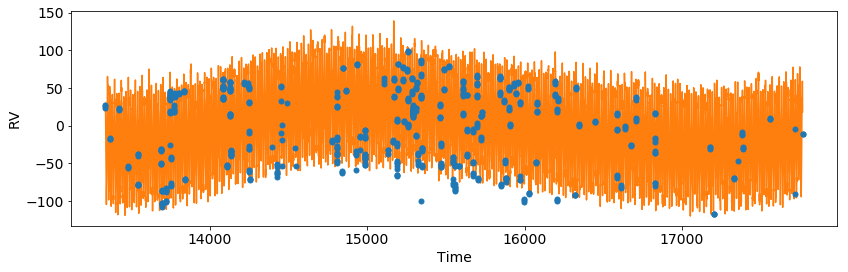

In [56]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [57]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]
post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],.25*like.params['per4'])]
post.priors += [radvel.prior.Gaussian('per5',like.params['per5'],.25*like.params['per5'])]
post.priors += [radvel.prior.Gaussian('per6',like.params['per6'],.25*like.params['per6'])]


post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6518       True
tc1                          2074.5       True
secosw1                   0.0409944       True
sesinw1                    0.109144       True
logk1                       4.26193       True
per2                        3775.05       True
tc2                         867.559       True
secosw2                   0.0721263       True
sesinw2                   -0.438416       True
logk2                       3.41643       True
per3                        44.3905       True
tc3                         2082.64       True
secosw3                    0.541054       True
sesinw3                     0.18203       True
logk3                       2.33923       True
per4                        2.94665       True
tc4                         1084.94       True
secosw4                     0.26393       True
sesinw4                   -0.899185       True
logk4                       1.78685       True
per5          

parameter                     value      vary
per1                        14.6517       True
tc1                         2074.58       True
secosw1                   0.0552435       True
sesinw1                    0.138916       True
logk1                       4.26449       True
per2                         3807.1       True
tc2                         689.195       True
secosw2                    0.104569       True
sesinw2                   -0.423462       True
logk2                       3.43502       True
per3                        44.3927       True
tc3                         2081.28       True
secosw3                    0.585159       True
sesinw3                    0.220253       True
logk3                       2.41763       True
per4                        2.94664       True
tc4                         1084.89       True
secosw4                    0.285008       True
sesinw4                   -0.901787       True
logk4                       1.92337       True
per5          

C:\Users\rscsa\Anaconda2\lib\site-packages\radvel\utils.py:205: RuntimeWarning: invalid value encountered in divide
  bindat = sy / n
C:\Users\rscsa\Anaconda2\lib\site-packages\radvel\utils.py:206: RuntimeWarning: invalid value encountered in divide
  binerr = np.sqrt(sy2/n - bindat*bindat) / np.sqrt(n)


(<matplotlib.figure.Figure at 0x1a522fd0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1c063ef0>])

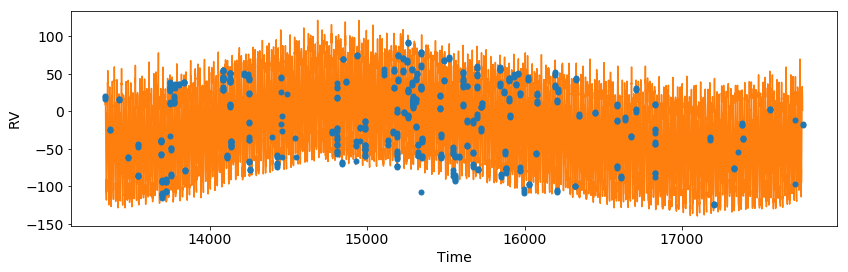

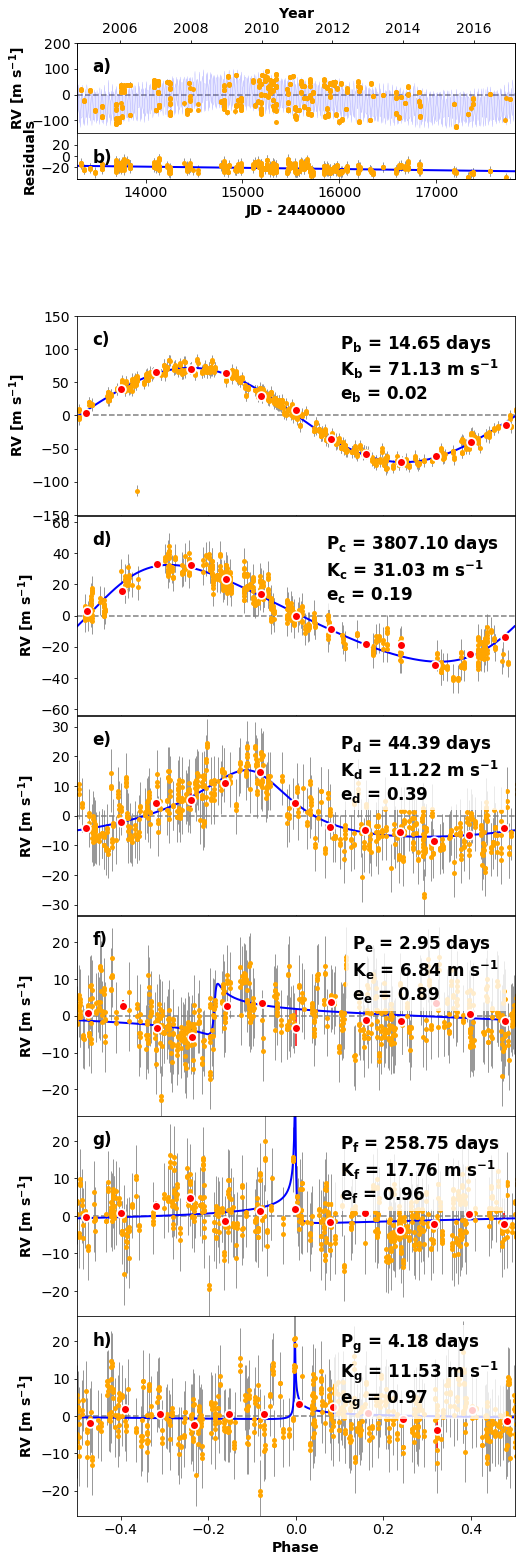

In [58]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [59]:
Residuals_Radvel_6 = post.likelihood.residuals()
RMS_Radvel_6 = RMS(Residuals_Radvel_6)
print 'Radvel RMS of Residuals: ', RMS_Radvel_6
print ' '
print ' '

#model likelihood
six_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  8.69591489397
 
 
N_free = 34
RMS = 8.70
logprob (jitter fixed) = -2240.70
chi (jitter fixed) = 676.61
chi_red (jitter fixed) = 1.14
BIC (jitter fixed) = 4521.84


# Initial Best Fit My Own Way (6th Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  15 to 1e+03
 - Computing periods at 1455 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 117.659412108


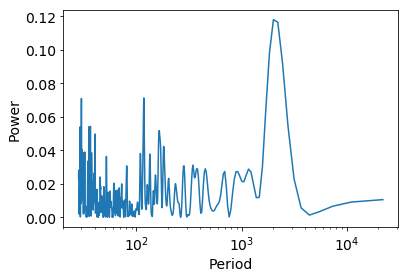

In [60]:
period6 = periodogram(t,residuals5,15,1000,nyquist)

Amplitude:  3.82534989167
Period:  117.704659419
Phase Shift:  1.05073814508
Vertical-Shift:  -2.60244101187e-05
RMS of Residuals:  9.31568481635
RMS 9.31568481635
Chi Square 35014.8035501


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


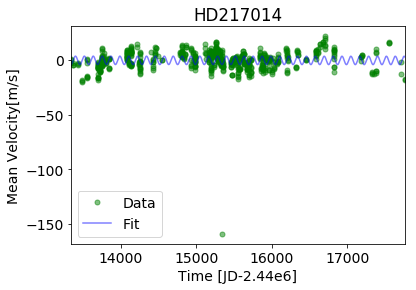

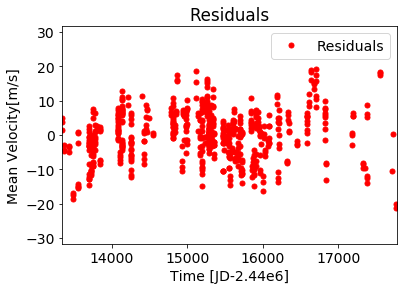

In [61]:
guess_amp = 10.
guess_pshft =0.
guess_vshft = 0.
residuals6, period6, likelihood6 = residuals(nplanets, t, residuals5, errvel, guess_amp, period6, guess_pshft, guess_vshft)

# Results

Periods of all Planets

In [62]:
header_likely = ['Method','1st Planet','2nd Planet', '3rd Planet', '4th Planet', '5th Planet', '6th Planet']
radvel_periods = ['Radvel',period1,period_radvel_2,period_radvel_3,period_radvel_4,period_radvel_5,period_radvel_6]
own_periods = ['Own',period1,period2,period3, period4,period5,period6]
print 'PERIODS FOR PLANETS'
print ''
print tabulate([radvel_periods, own_periods],headers=header_likely)

PERIODS FOR PLANETS

Method      1st Planet    2nd Planet    3rd Planet    4th Planet    5th Planet    6th Planet
--------  ------------  ------------  ------------  ------------  ------------  ------------
Radvel          14.653       3782.79       44.4069       2.81773       259.7         2.81712
Own             14.653       4264.07       44.3961       2.81734       263.689     117.705


Model Comparison using Radvel

In [63]:
header_likely = ['num_planets','# Data', 'Free Params', 'RMS', 'Logprob', 'chi', 'chi_red', 'BIC']
print 'MODEL COMPARISON RADVEL'
print ''
print tabulate([one_planet,two_planet,three_planet,four_planet,five_planet,six_planet],headers=header_likely)

MODEL COMPARISON RADVEL

  num_planets    # Data    Free Params       RMS    Logprob      chi    chi_red      BIC
-------------  --------  -------------  --------  ---------  -------  ---------  -------
            1       629              9  22.361     -2879.07  689.428    1.11198  5773.59
            2       629             14  14.8438    -2602.28  662.301    1.07691  5225.01
            3       629             19  10.0078    -2337.97  655.32     1.07429  4701.38
            4       629             24   9.45289   -2298.85  666.238    1.10122  4628.15
            5       629             29   8.73294   -2241.75  677.202    1.12867  4518.95
            6       629             34   8.69591   -2240.7   676.615    1.13717  4521.84


Model Comparison using my own method

In [64]:
print 'MODEL COMPARISON FOR OWN METHOD'
print ''
print tabulate([likelihood1,likelihood2,likelihood3,likelihood4,likelihood5,likelihood6],headers=header_likely)

MODEL COMPARISON FOR OWN METHOD

  num_planets    # Data    Free Params       RMS    Logprob       chi    chi_red        BIC
-------------  --------  -------------  --------  ---------  --------  ---------  ---------
            1       629              4  22.3551     4.55547  324902     519.843     1.33319
            2       629              4  12.6265   nan         82813.4   132.501   nan
            3       629              4  10.882    nan         54449.2    87.1187  nan
            4       629              4  10.1221   nan         44432      71.0913  nan
            5       629              4   9.66454  nan         38571.7    61.7147  nan
            6       629              4   9.31568  nan         35014.8    56.0237  nan


# Utilizing RadVel Module

Define a function that we will use to initialize the ``radvel.RVParameters`` and ``radvel.RVModel`` objects

curv                   -7.39154e-08       True
dvdt                   -0.000573222       True
gamma                       4.61095       True
jit                         11.2417       True
logk1                       4.24819       True
logk2                       3.42597       True
per1                        14.6521       True
per2                        3901.48       True
secosw1                   0.0647091       True
secosw2                   0.0836947       True
sesinw1                     0.10735       True
sesinw2                   -0.419884       True
tc1                         2074.21       True
tc2                         4268.95       True

# MCMC Chain

Now lets use Markov-Chain Monte Carlo (MCMC) to estimate the parameter uncertainties.

In [65]:
# df = radvel.mcmc(post,nwalkers=50,nrun=5000)

Now lets make a corner plot to display the posterior distributions.

In [66]:
# radvel.plotting.corner_plot(post, df)

In [67]:
# print post
# radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [68]:
"""
df['k1'] = np.exp(df['logk1'])
df['k2'] = np.exp(df['logk2'])
df['k3'] = np.exp(df['logk3'])
df['k4'] = np.exp(df['logk4'])
df['jit'] = np.exp(df['jit'])
df['e1'] = df['secosw1']**2 + df['sesinw1']**2
df['e2'] = df['secosw2']**2 + df['sesinw2']**2
df['e3'] = df['secosw3']**2 + df['sesinw3']**2
df['e4'] = df['secosw4']**2 + df['sesinw4']**2

df['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])
df['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])

df['ecosw2'] = df['secosw2']*np.sqrt(df['e2'])
df['esinw2'] = df['sesinw2']*np.sqrt(df['e2'])

df['ecosw3'] = df['secosw3']*np.sqrt(df['e3'])
df['esinw3'] = df['sesinw3']*np.sqrt(df['e3'])

df['ecosw4'] = df['secosw4']*np.sqrt(df['e4'])
df['esinw4'] = df['sesinw4']*np.sqrt(df['e4'])

labels = 'k1 k2 k3 k4 jit e1 e2 e3 e4'.split()
fig = corner.corner(
    df[labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20,
    quantiles=[.14,.5,.84,]
    )
"""

"\ndf['k1'] = np.exp(df['logk1'])\ndf['k2'] = np.exp(df['logk2'])\ndf['k3'] = np.exp(df['logk3'])\ndf['k4'] = np.exp(df['logk4'])\ndf['jit'] = np.exp(df['jit'])\ndf['e1'] = df['secosw1']**2 + df['sesinw1']**2\ndf['e2'] = df['secosw2']**2 + df['sesinw2']**2\ndf['e3'] = df['secosw3']**2 + df['sesinw3']**2\ndf['e4'] = df['secosw4']**2 + df['sesinw4']**2\n\ndf['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])\ndf['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])\n\ndf['ecosw2'] = df['secosw2']*np.sqrt(df['e2'])\ndf['esinw2'] = df['sesinw2']*np.sqrt(df['e2'])\n\ndf['ecosw3'] = df['secosw3']*np.sqrt(df['e3'])\ndf['esinw3'] = df['sesinw3']*np.sqrt(df['e3'])\n\ndf['ecosw4'] = df['secosw4']*np.sqrt(df['e4'])\ndf['esinw4'] = df['sesinw4']*np.sqrt(df['e4'])\n\nlabels = 'k1 k2 k3 k4 jit e1 e2 e3 e4'.split()\nfig = corner.corner(\n    df[labels],\n    labels=labels,\n    levels=[0.68,0.95],\n    plot_datapoints=False,\n    smooth=True,\n    bins=20,\n    quantiles=[.14,.5,.84,]\n    )\n"

In [69]:
# print post
# radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [70]:
a = radvel.posterior.bic()

AttributeError: 'module' object has no attribute 'bic'